# 디렉토리 설정 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/DataSet/KYR_B_imaging.zip
!cp '/content/drive/MyDrive/Colab Notebooks/프로젝트/ct분류/init.py' ./

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: KYR_B_imaging/20210910 임승이/2100037360020.jpg  
  inflating: KYR_B_imaging/20210910 임승이/2100052160001.jpg  
  inflating: KYR_B_imaging/20210910 임승이/2100052160002.jpg  
  inflating: KYR_B_imaging/20210910 임승이/2100052160003.jpg  
  inflating: KYR_B_imaging/20210910 임승이/2100052160004.jpg  
  inflating: KYR_B_imaging/20210910 임승이/2100052160005.jpg  
  inflating: KYR_B_imaging/20210910 임승이/2100052160006.jpg  
  inflating: KYR_B_imaging/20210910 임승이/2100052160007.jpg  
  inflating: KYR_B_imaging/20210910 임승이/2100052160008.jpg  
  inflating: KYR_B_imaging/20210910 임승이/2100052160009.jpg  
  inflating: KYR_B_imaging/20210910 임승이/2100052160010.jpg  
  inflating: KYR_B_imaging/20210910 임승이/2100052160011.jpg  
  inflating: KYR_B_imaging/20210910 임승이/2100052160012.jpg  
  inflating: KYR_B_imaging/20210910 임승이/2100052160013.jpg  
  inflating: KYR_B_imaging/20210910 임승이/2100052160014.jpg  
  inflating: KYR_B_imaging/20210910 임승이/2100052160015.jpg  
  in

In [ ]:
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr3' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr2 74' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr5' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr1' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr7' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr8' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr4' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/nswr1' '/content/KYR_B_imaging' 
!cp -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱/swr6' '/content/KYR_B_imaging' 
!rm -r '/content/KYR_B_imaging/20201224 DL_MRI_SNSB_임승욱'

# 초기작업
- 데이터 제너레이터에 넣을 수 있는 기본형태를 만드는 것 

## 기본 DF 생성 
- csv 데이터인 snsb_df 
- 이미지 디렉토리 관련인 dir_df만듬 

전처리 과정에서 
- snsb_df -> csvs 
- dir_df -> new_dir_df로 변환 함 


In [ ]:
import os 
import cv2 
import pandas as pd 
from glob import glob
from tqdm import tqdm
from init import init #초기 설정용 커스텀 패키지 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.pyplot as cm 
import warnings
warnings.filterwarnings('ignore')
from albumentations import (
    Rotate,Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate,JpegCompression
)

###snsb_df 생성 
- 환자 정보 데이터 프레임 

In [ ]:
columns = ['성명',
 '병록번호',
 '만나이',
 '검사일',
 '교육년수',
 'SVLT_recall_total_score_z',
 'SVLT_Delayed_recall_z',
 'SVLT_recognition_score_z',
 'RCFT_immediate_recall_z',
 'RCFT_delayed_recall_z',
 'RCFT_recognition_score_z',
 'K_MMSE_total_score_z',
 'SNSB_II_Domain_Attention_z',
 'SNSB_II_Domain_Language_z',
 'SNSB_II_Domain_Visuospatial_z',
 'SNSB_II_Domain_Memory_z',
 'SNSB_II_Domain_Frontal_z']

snsb_df = pd.read_csv('/content/drive/MyDrive/DataSet/202202_김예림/SNSB_integerated.csv')
snsb_df = snsb_df.drop([2098,2591]) #병록번호 없는 행 제거 <- 결측치 
snsb_df['병록번호'] = snsb_df['병록번호'].apply(lambda x : str(int(x))) #소수점으로 되어 있는 것 처리하고 str형 변형 

snsb_df = snsb_df[columns]

## 결측치 처리 

#컬럼 중 isnull 검색 
#검색한 표본들의 평균 나이 
#평균 나이로 원래  csvs 검색 
#해당 나이로 검색 된 것들의 평균 값으로 insull 채움 

null_columns = ['RCFT_immediate_recall_z',
                'SVLT_recall_total_score_z',
                'SVLT_Delayed_recall_z',
                'SVLT_recognition_score_z',
'RCFT_delayed_recall_z',            
'RCFT_recognition_score_z',        
'K_MMSE_total_score_z',           
'SNSB_II_Domain_Attention_z',       
'SNSB_II_Domain_Language_z',        
'SNSB_II_Domain_Visuospatial_z',    
'SNSB_II_Domain_Memory_z',          
'SNSB_II_Domain_Frontal_z']         

for null_column in null_columns:
  try:
    null_age = int(np.mean(snsb_df[snsb_df[null_column].isnull()]['만나이']))
    null_value = np.mean(snsb_df[snsb_df['만나이']==null_age][null_column].dropna())
    snsb_df.loc[snsb_df[null_column].isnull(),null_column] = null_value
  except:
    pass

###dir_df 생성 
- 환자  별 mri 디렉토리 데이터 프레임 
- 이미지 장수 정리 안된 데이터 프레임 

In [ ]:
#폴더 디렉토리
folder_dir = glob('/content/KYR_B_imaging/*')
dir_df = init.dir_df(folder_dir)
dir_df = dir_df.sort_values(by=['key','dir'])
dir_df = dir_df.reset_index().drop(columns = 'index')

### 병록번호- key 값 보정
- 병록번호 == key 하게 만들어야 함 -> primary key 
- 중복 제거, @@@-1 형태 제거, 9자리로 통일 

In [ ]:
target_length = [4,5,6,7,8] #<- 수정해야 하는 병록번호 갯수들 

dir_df,snsb_df = init.key_mismatch(dir_df,snsb_df,target_length)
#인덱스 초기화 
dir_df = dir_df.reset_index().drop(columns = 'index')
# plt.hist(snsb_df['병록번호'].map(len))
# plt.show()

#에러값들 제외 
errors = ['000758836-1' '030338456-1' '040145556-1' '050236926-1' '090374796-1'
 '100402746-1' '120010356-1' '870133669-1' '920033543-1' '930236559-1'
 '930257597-1' '970682600-1']

dir_df = dir_df.drop(np.where(dir_df['key'].map(len)>9)[0])

## new_dir_df 생성 - 이미지 장수 통일 
- 위에서 만든 dir_df에서 각 key 별로 이미지 19장으로 맞춤 
- 19장으로 맞추는 이유는 가장 비율이 높아서 


### key 값 별 이미지 장수 연산 

In [ ]:
#이미지 장수 연산 
keys = list(set(dir_df['key'])) 
images_length = pd.DataFrame(keys)[0].apply(lambda x: init.check_images(dir_df,x)) #키 값별로 이미지의 장수들 계산 
# images_length.value_counts()

length_df = pd.DataFrame([keys,images_length]).T
length_df.columns = ['key','image_length']
length_df['image_length']  = length_df['image_length'].map(int)

#Standard를 기준으로 less over 분할 
standard = 19 # 통일 시킬 이미지 장 수 기준 

# 조정이 필요한 장 수 초과하는 것들만 추림 
length_df_over = length_df[length_df['image_length']>standard]

#19장 보다 적은 경우 
# length_df_less = length_df[length_df['image_length']<standard]

len(length_df_over)

1606

### key값 별로 이미지 19장 있는 new_dir_df 생성 

In [ ]:
new_dir_df = pd.DataFrame(np.zeros(len(length_df_over)*19*2).reshape(-1,2))
new_dir_df.columns = dir_df.columns

for index in tqdm(range(len(length_df_over))):
  new_dir_df.iloc[index*19:(index+1)*19,:]  = dir_df.loc[init.droped_indexes(dir_df,length_df_over,index,standard=19)]
new_dir_df = new_dir_df.sort_values(by=['key','dir'])
new_dir_df = new_dir_df.reset_index().drop(columns = 'index')

100%|██████████| 1606/1606 [00:07<00:00, 212.61it/s]


## csvs 생성 
 - 중복 제거 
 - z score -1.0를 기준으로 0(정상) 1(비정상)으로 분류 



In [ ]:
#19장의 사진으로 추린 new_dir_df로 새로운 키 리스트만듬) 

key_lists = np.unique(new_dir_df['key'])
key_lists.sort()

Embedding_columns = snsb_df.columns[5:]

for column in Embedding_columns:
  snsb_df[f'E_{column}'] = snsb_df[column].map(init.zscore_Embedding)

#정렬 
snsb_df = snsb_df.sort_values(by=['병록번호'])
new_dir_df = new_dir_df.sort_values(by=['key','dir'])

#snsb_df 중 key_lists에 있는 행들만 추림 -> csvs 
csvs = snsb_df[snsb_df['병록번호'].apply(lambda x : x in key_lists)].sort_values(by=['병록번호'])
csvs = csvs.reset_index().drop(columns = 'index')

#중복 제거 : 이름으로 정렬 후 중복 제거 
csvs = csvs.sort_values(by=['성명'])
csvs = csvs.drop_duplicates(['병록번호'], keep = 'first')

#다시 병록번호 로 정렬 해서 csvs 와 new_dir_df 순을 맞춤 
csvs = csvs.sort_values(['병록번호'])
csvs = csvs.reset_index().drop(columns = 'index')
new_dir_df = new_dir_df.sort_values(by=['key','dir'])
new_dir_df = new_dir_df.reset_index().drop(columns = 'index')

#맞춤 확인 
print(len(csvs),len(np.unique(new_dir_df['key'])))

1606 1606


# 전처리

## Augmentation 

In [ ]:
import albumentations as A
transform = A.Compose([
    RandomBrightness(limit=0.1),
    JpegCompression(quality_lower=85, 
                    quality_upper=100, p=0.5), 
    HueSaturationValue(hue_shift_limit=20,
                        sat_shift_limit=30, 
                    val_shift_limit=20, p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

## 이미지 전처리

In [ ]:
def plot_img(temp_img):
  plt.figure(figsize=(10,10))
  plt.imshow(temp_img)
  plt.show()

In [ ]:
#이미지 전처리 
def img_preprocess(img):
  shape = img.shape[0]
  preprocessed_img = img[int(shape*0.05):int(shape*0.95),int(shape*0.1):int(shape*0.9),:] #crop 
  # preprocessed_img = transform(image=preprocessed_img)['image']
  preprocessed_img = cv2.cvtColor(preprocessed_img,cv2.COLOR_BGR2GRAY)
  preprocessed_img = cv2.resize(preprocessed_img,dsize=(image_size,image_size)) #resize Albu mentations -> vision 관련 augmentation document 
  preprocessed_img = preprocessed_img/255.
  return preprocessed_img 

def key_to_dir(key,new_dir_df):
  dir_of_key = new_dir_df[new_dir_df['key']==key]
  return dir_of_key



def read_imgs(img_dir_df): #224, 224, 19 용 
  temp_imgs = np.zeros(image_size*image_size*image_channels).reshape(image_size,image_size,image_channels)
  for i in range(len(img_dir_df)):
    temp_img = img_dir_df['dir'].iloc[i]
    temp_img = img_preprocess(cv2.imread(temp_img))
    temp_imgs[:,:,i] = temp_img 
  return temp_imgs

# 데이터 제너레이터

## 사전설정

In [ ]:
input_columns = ['만나이','교육년수']
output_columns = ['E_SVLT_recall_total_score_z', 'E_SVLT_Delayed_recall_z',
       'E_SVLT_recognition_score_z', 'E_RCFT_immediate_recall_z',
       'E_RCFT_delayed_recall_z', 'E_RCFT_recognition_score_z',
       'E_K_MMSE_total_score_z', 'E_SNSB_II_Domain_Attention_z',
       'E_SNSB_II_Domain_Language_z', 'E_SNSB_II_Domain_Visuospatial_z',
       'E_SNSB_II_Domain_Memory_z', 'E_SNSB_II_Domain_Frontal_z']
output_column = 'SVLT_recall_total_score_z'


image_size = 256
image_channels = 19 
BATCH_SIZE= 32

## !!!제너레이터

키 리스트를 이용해 train, valid, test 분리 

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
import math


class DataGenerator(Sequence):
  def __init__(self,
                 new_dir_df,
                 csvs,
                 key_lists,
                 output_column,
                 batch_size: int,
                 augmentation: bool = False,
                 shuffle: bool = False,
                 rescale:bool = True) -> None:
        self.input_columns = input_columns 
        self.key_lists = key_lists
        self.output_columns = output_column
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.rescale =rescale
        self.new_dir_df = new_dir_df
        self.csvs = csvs

  def __len__(self):
    return math.ceil(len(self.key_lists) / self.batch_size)
    
  def on_epoch_end(self):
    self.indices = np.arange(len(self.key_lists))
    if self.shuffle == True:
      np.random.shuffle(self.indices)
      self.key_lists = self.key_lists[self.indices]

  def __getitem__(self, index):
    self.batch_keys = self.key_lists[index*self.batch_size:(index+1)*self.batch_size]
    self.batch_keys.sort()

    #imgs 
    temp_imgs = []
    for key in range(len(self.batch_keys)):
      img_dir_df = key_to_dir(self.batch_keys[key],self.new_dir_df)
      temp_img = read_imgs(img_dir_df)
      temp_imgs.append(temp_img)
    input_imgs = np.array(temp_imgs).astype(np.float)

    #input_csvs
    temp_csvs = self.csvs[self.csvs['병록번호'].apply(lambda x: x in self.batch_keys)]
    temp_csvs = temp_csvs.sort_values(by=['병록번호'])
    temp_csvs = temp_csvs.reset_index().drop(columns='index')
    input_csvs = temp_csvs[input_columns]
    input_csvs = (np.array(input_csvs)-csvs_input_min)/(csvs_input_max-csvs_input_min)
    input_csvs = np.array(input_csvs)

    #output_csvs
    temp_csvs = self.csvs[self.csvs['병록번호'].apply(lambda x: x in self.batch_keys)]
    temp_csvs = temp_csvs.sort_values(by=['병록번호'])
    temp_csvs = temp_csvs.reset_index().drop(columns='index')
    output_csvs = temp_csvs[self.output_columns]
    output_csvs = np.array(output_csvs)
    output_csvs = (output_csvs - csvs_output_0_min)/(csvs_output_0_max-csvs_output_0_min).astype(np.float)

    return [input_imgs,input_csvs],output_csvs
    # return input_imgs,output_csvs


#모델

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import Recall
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional, LSTM, GRU, Activation, AveragePooling2D,ConvLSTM1D
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D,Activation,Dropout,Dense,Flatten,Input,Conv3D,MaxPooling3D
from tensorflow.keras.layers import Conv3D, ConvLSTM2D, BatchNormalization, Input, Dropout, Bidirectional, Conv1D, MaxPooling1D,Reshape
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.applications import resnet50, efficientnet,VGG19,EfficientNetV2S, NASNetLarge, ResNet50V2, vgg19,resnet_v2,efficientnet_v2
from tensorflow.keras.applications import ResNet50, EfficientNetB0, DenseNet169, MobileNet,EfficientNetB4, ResNet152V2, EfficientNetV2B0
import math
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from keras.layers.pooling import GlobalAveragePooling2D,GlobalAveragePooling3D,AveragePooling3D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay

## !!!모델 사전 정의

In [ ]:
res50 = ResNet50V2(weights='imagenet', include_top=False, input_shape=(image_size, image_size,3)) #size -> 256, 256 
res50.trainable = False

vgg_19 = VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size,3)) #size -> 256, 256 
vgg_19.trainable = False

effv2 = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(image_size, image_size,3)) #size -> 256, 256 
effv2.trainable = False

82436096/82420632 [==============================] - 2s 0us/step


In [ ]:
def input_to_pre(image_input): #224,224,19
  x = Conv2D(16, (2,2), padding ='same',activation = 'relu')(image_input)
  x = BatchNormalization()(x)
  x = Dropout(0.2)(x)
  # x = Conv2D(8, (2,2), padding ='same',activation = 'relu')(x)
  # x = BatchNormalization()(x)
  # x = Dropout(0.2)(x)
  out = Conv2D(3, (2,2), padding ='same',activation = 'relu')(x)
  return out 

def image_encoder_layer(filters,img_input):
  img = Conv2D(filters,(3,3),padding='same')(img_input)
  img = Dropout(0.2)(img)
  img_output = BatchNormalization()(img)
  return img_output


def image_encoder(image_combined):
  # img = image_encoder_layer(1024,image_combined)
  # img = image_encoder_layer(512,image_combined)
  # img = image_encoder_layer(256,image_combined)
  img_out = image_encoder_layer(128,image_combined)
  return img_out

def csvs_layers(filters,csv_input):
  csv = Dense(filters, activation = 'relu')(csv_input)
  csv = Dropout(0.2)(csv)
  csv_layer_out = BatchNormalization()(csv)
  return csv_layer_out

def csvs_decoder(csvs_input):
  # csvs = csvs_layers(32,csvs_input)
  # csvs = csvs_layers(64,csvs)
  csvs_out = csvs_layers(128,csvs_input)
  return csvs_out
  


## 콜백

In [ ]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
# loss 실시간 출력 
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):

    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

#call backs 선언
plot_losses = PlotLosses()

from tensorflow.keras.callbacks import ModelCheckpoint #<- model 저장 객체, best_model.h5라는 모델 이 저장 됨 
model_check_point = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True)


from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # 모니터링 대상, 이걸 기준으로 멈춤 
    verbose=1,
    patience=35)         # 중지까지의 여유분

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', # 모니터링 대상
    patience=10,        # 대상ㅃ 기간동안 유지
    factor=0.2,         # 줄이는 양                              
    min_learning_rate=0.00001)     # 최소 학습율

callbacks = [ plot_losses]

## !!!모델 

In [ ]:
#image input 
def make_model():
  image_input = Input((image_size,image_size,19))
  image = input_to_pre(image_input)

  # conv 
  res = resnet_v2.preprocess_input(image)
  res = res50(res)
  res = image_encoder(res)

  vgg = vgg19.preprocess_input(image)
  vgg = vgg_19(vgg)
  vgg = image_encoder(vgg)

  eff = efficientnet_v2.preprocess_input(image)
  eff = effv2(eff)
  eff = image_encoder(eff)

  # image combined 
  image_combined = concatenate([res,vgg,eff])
  image_combined = Conv2D(128, (2,2), padding = 'same')(image_combined)
  image_out = GlobalAveragePooling2D()(image_combined)


  #csv 
  csvs_input = Input((2))
  csvs_out = csvs_decoder(csvs_input)


  #image csv combined 
  combined = concatenate([image_out,csvs_out])

  #out 
  out = Dense(1,activation='sigmoid')(combined)

  model = Model([image_input,csvs_input],out)
  return model


## !!!Compile - Train

In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

In [ ]:
initial_learning_rate = 0.0005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

In [ ]:
optimizer = tfa.optimizers.RectifiedAdam(
    learning_rate=lr_schedule,
    total_steps=10000,
    warmup_proportion=0.1,
    min_lr=1e-5,
)

## Cross validation

In [ ]:
output_column = 'SVLT_recall_total_score_z'

input_columns = ['만나이','교육년수']

def minmax(index,out_column):
  scaling_value = np.array(csvs[out_column].iloc[index])
  min = np.min(scaling_value,axis=0)
  max = np.max(scaling_value,axis=0)
  return max,min

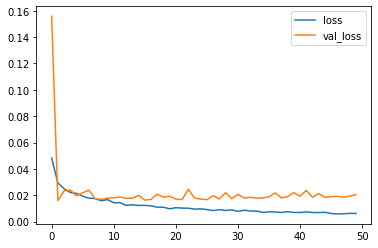

loss =  0.00618344871327281 , val_loss =  0.020417433232069016
37/37 [==============================] - 183s 5s/step - loss: 0.0062 - mae: 0.0631 - val_loss: 0.0204 - val_mae: 0.1131


In [ ]:
model_lists = []
history_lists = []

#Stratified Kfold indexing 용 
test_index = np.arange(1446,1606)
x = key_indexes = np.arange(1445)
y = np.array(csvs[output_columns[0]][:1445])

#Stratified Kfold 
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(x, y)
for train_index, valid_index in skf.split(x, y):

  #minmax scaling 용 0
  csvs_input_max, csvs_input_min = minmax(train_index,input_columns)
  csvs_output_0_max,csvs_output_0_min = minmax(train_index, output_column)

  #제너레이터 
  train_generator = DataGenerator(new_dir_df,
                                csvs,
                                key_lists[train_index],
                                output_column,
                                batch_size=BATCH_SIZE,
                                  shuffle=True)
  valid_generator = DataGenerator(new_dir_df,
                                csvs,
                                key_lists[valid_index],
                                output_column,
                                batch_size=BATCH_SIZE,
                                shuffle=False)
  test_generator = DataGenerator(new_dir_df,
                               csvs,
                               key_lists[test_index],
                               output_column,
                               batch_size=BATCH_SIZE,
                               shuffle=False)
  model = make_model()
  model.compile(optimizer=optimizer,loss = 'mse',metrics=['mae'])
  history = model.fit(train_generator,validation_data = valid_generator, epochs=50,verbose=1,callbacks=callbacks)
  
  model_lists.append(model)
  history_lists.append(history)
  #Batch : 32 + output:0 + isize:256 + Radam + init : 0.0005 + Expo decay + s Kfold 

In [ ]:
for i in range(len(model_lists)):
  model = model_lists[i]
  model.save(f'Ex_{i}.h5')

# Test 평가 

In [ ]:
def descaling(value):
  origin = value*(csvs_output_0_max-csvs_output_0_min) + csvs_output_0_min
  return origin
def temp(value):
  if value >=-1:
    return 0 
  else:
    return 1 
def score_regression_predict(model,generator,index):
  y_ = model.predict(generator)
  predicted = pd.DataFrame(y_)[0].map(descaling)
  y_predicted = predicted.map(temp)
  from sklearn.metrics import classification_report

  y_true = np.array(csvs[csvs['병록번호'].apply(lambda x : x in key_lists[index])][output_columns[0]])
  print(classification_report(y_true,y_predicted,target_names = ['0','1']))

## Train 

              precision    recall  f1-score   support

           0       0.80      0.67      0.73       504
           1       0.77      0.87      0.82       652

    accuracy                           0.78      1156
   macro avg       0.79      0.77      0.77      1156
weighted avg       0.78      0.78      0.78      1156



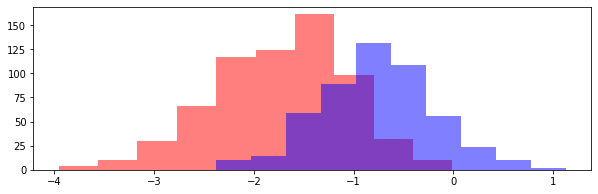

              precision    recall  f1-score   support

           0       0.51      1.00      0.67       505
           1       0.99      0.26      0.41       651

    accuracy                           0.58      1156
   macro avg       0.75      0.63      0.54      1156
weighted avg       0.78      0.58      0.52      1156



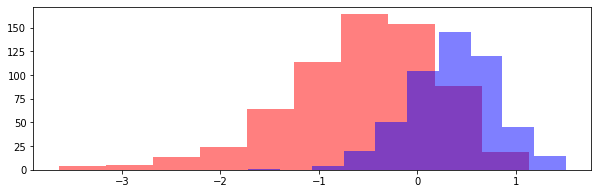

              precision    recall  f1-score   support

           0       0.66      0.97      0.78       505
           1       0.96      0.61      0.75       651

    accuracy                           0.77      1156
   macro avg       0.81      0.79      0.77      1156
weighted avg       0.83      0.77      0.76      1156



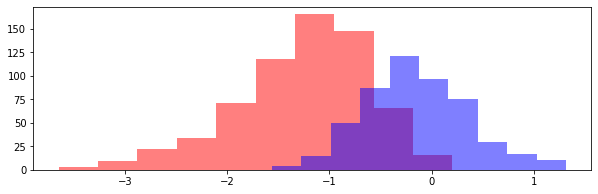

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       505
           1       0.84      0.85      0.85       651

    accuracy                           0.83      1156
   macro avg       0.83      0.82      0.82      1156
weighted avg       0.83      0.83      0.83      1156



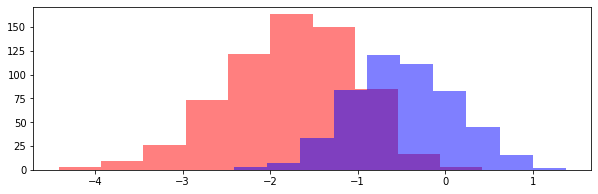

              precision    recall  f1-score   support

           0       0.66      0.96      0.78       505
           1       0.95      0.62      0.75       651

    accuracy                           0.77      1156
   macro avg       0.81      0.79      0.77      1156
weighted avg       0.83      0.77      0.76      1156



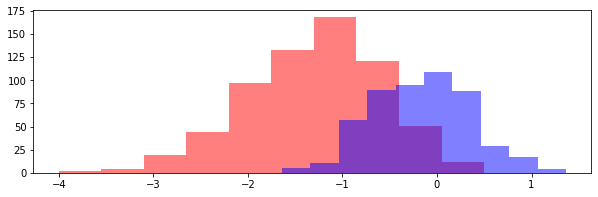

In [ ]:
test_index = np.arange(1446,1606)
x = key_indexes = np.arange(1445)
y = np.array(csvs[output_columns[0]][:1445])

predicted_train_lists = [] 

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(x, y)
n = 0 
for train_index, valid_index in skf.split(x, y):
  train_generator = DataGenerator(new_dir_df,
                                csvs,
                                key_lists[train_index],
                                output_column,
                                batch_size=BATCH_SIZE,
                                  shuffle=True)
  valid_generator = DataGenerator(new_dir_df,
                                csvs,
                                key_lists[valid_index],
                                output_column,
                                batch_size=BATCH_SIZE,
                                shuffle=False)
  test_generator = DataGenerator(new_dir_df,
                               csvs,
                               key_lists[test_index],
                               output_column,
                               batch_size=BATCH_SIZE,
                               shuffle=False)
  model = model_lists[n]
  y_ = model.predict(train_generator)
  
  predicted = pd.DataFrame(y_)[0].map(descaling)
  predicted_train_lists.append(predicted)


  y_predicted = predicted.map(temp)
  from sklearn.metrics import classification_report
  y_true = np.array(csvs[csvs['병록번호'].apply(lambda x : x in key_lists[train_index])][output_columns[0]])
  print(classification_report(y_true,y_predicted,target_names = ['0','1']))
  true_1 = np.where(y_true==1)
  true_0 = np.where(y_true==0)

  plt.figure(figsize=(10,3))
  plt.hist(predicted.iloc[true_1],color='r',alpha=0.5)
  plt.hist(predicted.iloc[true_0],color='b',alpha=0.5)
  plt.show()
  n+=1
  


## Valid

              precision    recall  f1-score   support

           0       0.59      0.43      0.49       127
           1       0.63      0.77      0.69       162

    accuracy                           0.62       289
   macro avg       0.61      0.60      0.59       289
weighted avg       0.61      0.62      0.60       289



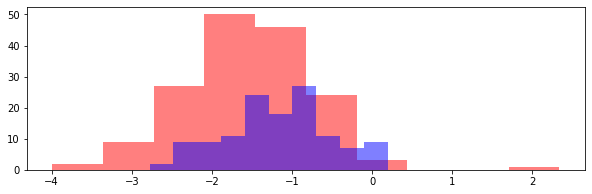

              precision    recall  f1-score   support

           0       0.46      0.94      0.62       126
           1       0.79      0.16      0.27       163

    accuracy                           0.50       289
   macro avg       0.63      0.55      0.44       289
weighted avg       0.65      0.50      0.42       289



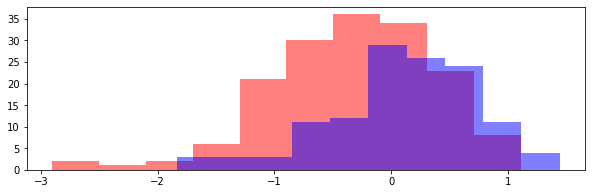

              precision    recall  f1-score   support

           0       0.48      0.71      0.57       126
           1       0.64      0.41      0.50       163

    accuracy                           0.54       289
   macro avg       0.56      0.56      0.54       289
weighted avg       0.57      0.54      0.53       289



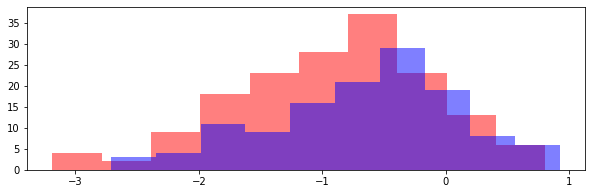

              precision    recall  f1-score   support

           0       0.56      0.50      0.53       126
           1       0.64      0.69      0.67       163

    accuracy                           0.61       289
   macro avg       0.60      0.60      0.60       289
weighted avg       0.61      0.61      0.61       289



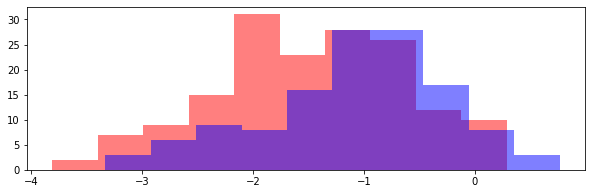

              precision    recall  f1-score   support

           0       0.51      0.79      0.62       126
           1       0.72      0.41      0.52       163

    accuracy                           0.58       289
   macro avg       0.62      0.60      0.57       289
weighted avg       0.63      0.58      0.57       289



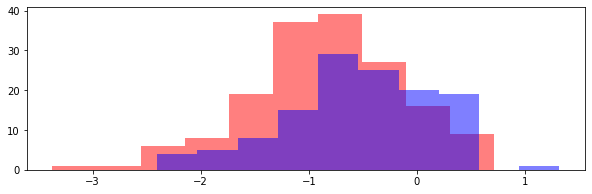

In [ ]:
test_index = np.arange(1446,1606)
x = key_indexes = np.arange(1445)
y = np.array(csvs[output_columns[0]][:1445])

predicted_valid_lists = [] 

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(x, y)
n = 0 
for train_index, valid_index in skf.split(x, y):

  train_generator = DataGenerator(new_dir_df,
                                csvs,
                                key_lists[train_index],
                                output_column,
                                batch_size=BATCH_SIZE,
                                  shuffle=True)
  valid_generator = DataGenerator(new_dir_df,
                                csvs,
                                key_lists[valid_index],
                                output_column,
                                batch_size=BATCH_SIZE,
                                shuffle=False)
  test_generator = DataGenerator(new_dir_df,
                               csvs,
                               key_lists[test_index],
                               output_column,
                               batch_size=BATCH_SIZE,
                               shuffle=False)
  model = model_lists[n]
  y_ = model.predict(valid_generator)
  predicted = pd.DataFrame(y_)[0].map(descaling)

  predicted_valid_lists.append(predicted)



  y_predicted = predicted.map(temp)
  from sklearn.metrics import classification_report
  y_true = np.array(csvs[csvs['병록번호'].apply(lambda x : x in key_lists[valid_index])][output_columns[0]])
  print(classification_report(y_true,y_predicted,target_names = ['0','1']))
  true_1 = np.where(y_true==1)
  true_0 = np.where(y_true==0)

  plt.figure(figsize=(10,3))
  plt.hist(predicted.iloc[true_1],color='r',alpha=0.5)
  plt.hist(predicted.iloc[true_0],color='b',alpha=0.5)
  plt.show()
  n+=1
  


## Test 

              precision    recall  f1-score   support

           0       0.57      0.43      0.49        74
           1       0.60      0.72      0.65        86

    accuracy                           0.59       160
   macro avg       0.58      0.58      0.57       160
weighted avg       0.58      0.59      0.58       160



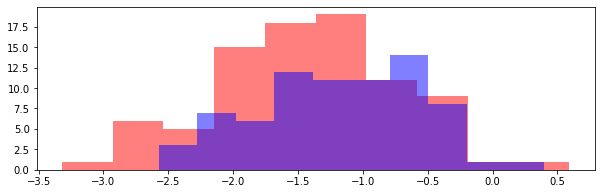

              precision    recall  f1-score   support

           0       0.48      0.97      0.64        74
           1       0.80      0.09      0.17        86

    accuracy                           0.50       160
   macro avg       0.64      0.53      0.40       160
weighted avg       0.65      0.50      0.39       160



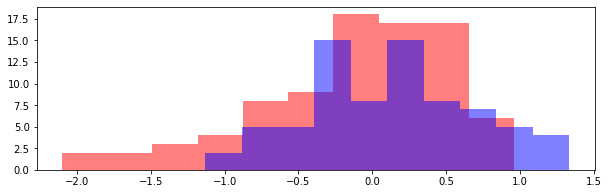

              precision    recall  f1-score   support

           0       0.50      0.77      0.60        74
           1       0.62      0.33      0.43        86

    accuracy                           0.53       160
   macro avg       0.56      0.55      0.52       160
weighted avg       0.56      0.53      0.51       160



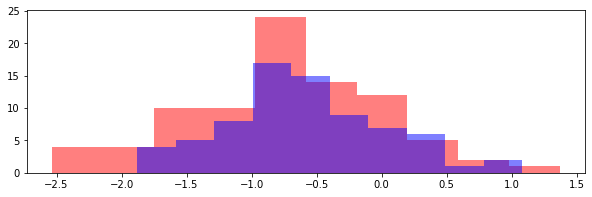

              precision    recall  f1-score   support

           0       0.51      0.49      0.50        74
           1       0.58      0.60      0.59        86

    accuracy                           0.55       160
   macro avg       0.55      0.55      0.55       160
weighted avg       0.55      0.55      0.55       160



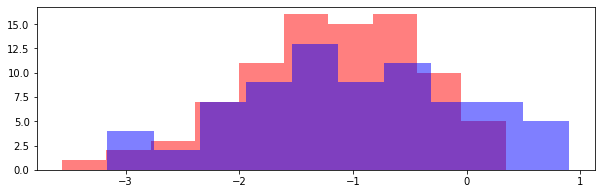

              precision    recall  f1-score   support

           0       0.51      0.74      0.61        74
           1       0.64      0.40      0.49        86

    accuracy                           0.56       160
   macro avg       0.58      0.57      0.55       160
weighted avg       0.58      0.56      0.54       160



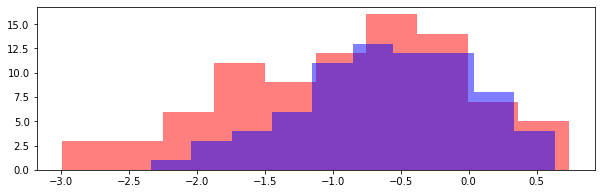

In [ ]:
test_index = np.arange(1446,1606)
x = key_indexes = np.arange(1445)
y = np.array(csvs[output_columns[0]][:1445])

predicted_test_lists = []

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(x, y)
n = 0 
for train_index, valid_index in skf.split(x, y):

  train_generator = DataGenerator(new_dir_df,
                                csvs,
                                key_lists[train_index],
                                output_column,
                                batch_size=BATCH_SIZE,
                                  shuffle=True)
  valid_generator = DataGenerator(new_dir_df,
                                csvs,
                                key_lists[valid_index],
                                output_column,
                                batch_size=BATCH_SIZE,
                                shuffle=False)
  test_generator = DataGenerator(new_dir_df,
                               csvs,
                               key_lists[test_index],
                               output_column,
                               batch_size=BATCH_SIZE,
                               shuffle=False)
  model = model_lists[n]
  y_ = model.predict(test_generator)
  predicted = pd.DataFrame(y_)[0].map(descaling)
  predicted_test_lists.append(predicted)

  y_predicted = predicted.map(temp)
  from sklearn.metrics import classification_report
  y_true = np.array(csvs[csvs['병록번호'].apply(lambda x : x in key_lists[test_index])][output_columns[0]])
  print(classification_report(y_true,y_predicted,target_names = ['0','1']))
  true_1 = np.where(y_true==1)
  true_0 = np.where(y_true==0)

  plt.figure(figsize=(10,3))
  plt.hist(predicted.iloc[true_1],color='r',alpha=0.5)
  plt.hist(predicted.iloc[true_0],color='b',alpha=0.5)
  plt.show()
  n+=1
  


## Loss plot

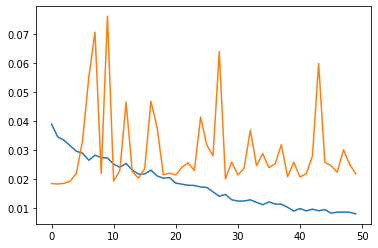

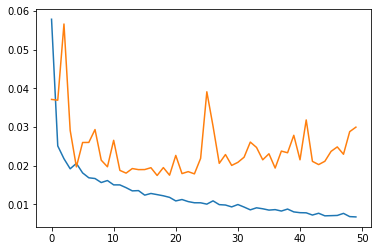

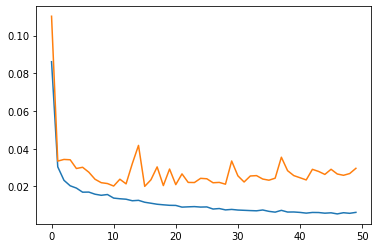

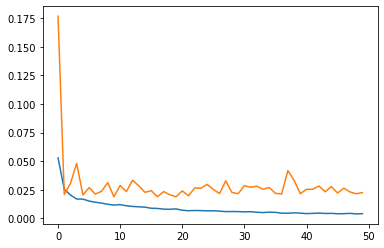

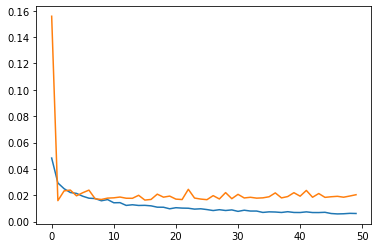

In [ ]:
for i in range(5):
  plt.plot(history_lists[i].history['loss'])
  plt.plot(history_lists[i].history['val_loss'])
  plt.show()

# 실험

In [ ]:
test_index = np.arange(1446,1606)
x = key_indexes = np.arange(1445)
y = np.array(csvs[output_columns[0]][:1445])

def temp(value):
  if value >=-1:
    return 0 
  else:
    return 1 

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(x, y)
n = 0 
for train_index, valid_index in skf.split(x, y):


  predicted = predicted_train_lists[n]
  y_predicted = predicted.map(temp)


  from sklearn.metrics import classification_report
  y_true = np.array(csvs[csvs['병록번호'].apply(lambda x : x in key_lists[train_index])][output_columns[0]])
  print(classification_report(y_true,y_predicted,target_names = ['0','1']))


  true_1 = np.where(y_true==1)
  true_0 = np.where(y_true==0)

  plt.figure(figsize=(10,3))
  plt.hist(predicted.iloc[true_1],color='r',alpha=0.5)
  plt.hist(predicted.iloc[true_0],color='b',alpha=0.5)
  plt.show()
  n+=1
  


In [ ]:
test_index = np.arange(1446,1606)
x = key_indexes = np.arange(1445)
y = np.array(csvs[output_columns[0]][:1445])
E_predicted = pd.DataFrame(np.zeros(1606*15).reshape(1606,15))

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(x, y)
n = 0 

for train_index, valid_index in skf.split(x, y):
  E_predicted.iloc[train_index,n] = np.array(predicted_train_lists)[n,:]
  E_predicted.iloc[valid_index,n+5] = np.array(predicted_valid_lists)[n,:]
  E_predicted.iloc[test_index,n+10] = np.array(predicted_test_lists)[n,:]
  n+=1

In [ ]:
E_predicted.to_csv('predicted.csv')

In [ ]:
def temp(value):
  if value ==0:
    return 0
  elif value >= -1:
    return 1
  else:
    return -1 

for n in range(5):
  E_predicted[n] = E_predicted[n].map(temp)

In [ ]:
y_pred = np.array(np.sum(E_predicted,axis=1)>=0).astype(np.int)
y_true = csvs[output_columns[0]][:1445]

# Save

In [ ]:
test_index = np.arange(1446,1606)
x = key_indexes = np.arange(1445)
y = np.array(csvs[output_columns[0]][:1445])
E_predicted = pd.DataFrame(np.zeros(1606*15).reshape(1606,15))

from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(x, y)
n = 0 

for train_index, valid_index in skf.split(x, y):
  E_predicted.iloc[train_index,n] = np.array(predicted_train_lists)[n,:]
  E_predicted.iloc[valid_index,n+5] = np.array(predicted_valid_lists)[n,:]
  E_predicted.iloc[test_index,n+10] = np.array(predicted_test_lists)[n,:]
  n+=1
E_predicted.to_csv('Ex2_predicted.csv')

In [ ]:
for i in range(len(model_lists)):
  model = model_lists[i]
  model.save(f'Ex_2_{i}.h5')
  model.save_weights(f'Ex_2_{i}_weight')

In [ ]:
!cp 'Ex2_predicted.csv' '/content/drive/MyDrive/DataSet/mri_model/실험2'


!cp 'Ex_2_0.h5' '/content/drive/MyDrive/DataSet/mri_model/실험2'
!cp 'Ex_2_0_weight.data-00000-of-00001' '/content/drive/MyDrive/DataSet/mri_model/실험2'
!cp 'Ex_2_0_weight.index' '/content/drive/MyDrive/DataSet/mri_model/실험2'

!cp 'Ex_2_1.h5' '/content/drive/MyDrive/DataSet/mri_model/실험2'
!cp 'Ex_2_1_weight.data-00000-of-00001' '/content/drive/MyDrive/DataSet/mri_model/실험2'
!cp 'Ex_2_1_weight.index' '/content/drive/MyDrive/DataSet/mri_model/실험2' 

!cp 'Ex_2_2.h5'	'/content/drive/MyDrive/DataSet/mri_model/실험2'	    
!cp 'Ex_2_2_weight.data-00000-of-00001' '/content/drive/MyDrive/DataSet/mri_model/실험2'
!cp 'Ex_2_2_weight.index' '/content/drive/MyDrive/DataSet/mri_model/실험2'

!cp 'Ex_2_3.h5' '/content/drive/MyDrive/DataSet/mri_model/실험2'
!cp 'Ex_2_3_weight.data-00000-of-00001' '/content/drive/MyDrive/DataSet/mri_model/실험2'
!cp 'Ex_2_3_weight.index' '/content/drive/MyDrive/DataSet/mri_model/실험2'

  
!cp 'Ex_2_4.h5' '/content/drive/MyDrive/DataSet/mri_model/실험2'
!cp 'Ex_2_4_weight.data-00000-of-00001' '/content/drive/MyDrive/DataSet/mri_model/실험2'
!cp 'Ex_2_4_weight.index' '/content/drive/MyDrive/DataSet/mri_model/실험2'